# Orange Telecom dataset. Predicting propensity to buy new products or services(appetency).
## Case of highly imbalanced data.

link: [https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro](https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro)


## Description
Customer Relationship Management (CRM) is a key element of modern marketing strategies. The KDD Cup 2009 offers the opportunity to work on large marketing databases from the French Telecom company Orange to predict the propensity of customers to switch provider (churn), buy new products or services (appetency), or buy upgrades or add-ons proposed to them to make the sale more profitable (up-selling). This project focuses only on predicting appetency.

## Data
The first 190 variables are numerical and the last 40 are categorical. 
The target values (.labels files) have one example per line in the same order as the corresponding data files. The target values are +1 or -1. We refer to examples having +1 (resp. -1) target values as positive (resp. negative) examples.
- Separator tabulation between the values
- There are missing values (consecutive tabulations)


## Table of contents
0. Loading data
1. Cleaning data
2. Looking at the target and class imbalance, EDA
3. Feature engeneering   
    3.1 Creating flag columns for numerical variables with high number of NAs  
4. Machine Learning   
    4.1 Random Forest  
        4.1.0 Random Forest w/o PCA and resampling (BASELINE)
        4.1.1 Random Forest, w/o PCA, Oversampling minority class
        4.1.2 Random Forest, w/o PCA, Undersampling majority class 
        4.1.3 Random Forest, w/o PCA, SMOTE
        4.1.4 Random Forest with SMOTE, PCA
        4.1.5 Random Forest with SMOTE, PCA, full dataset with NA columns and no flag columns
        4.1.6 Random Forest with SMOTE, full dataset and flags
    4.2 Logistic Regression
        4.2.1 Logistic regression with SMOTE, full dataset with NA columns and no flag columns
        4.2.2 Logistic regression with Undersampling, full dataset and PCA
        4.2.3 Logistic regression with Undersampling, full dataset and flags
    4.3 LGBM (Undersampling, full dataset, no PCA) 
        4.3.1 LGBM with no flag columns
        4.3.2 LGBM with flag columns
    4.4 XGBoost (Undersampling, full dataset, no PCA)  
    4.5 CatBoost(Undersampling, full dataset, no PCA)  
    4.6 Mahalanobis distance   
5. Conclusion

In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [277]:
import os
import pandas as pd
import numpy as np
import missingno as msn
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from category_encoders import CountEncoder, OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel, RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier, DistanceMetric, NearestNeighbors

import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import catboost as cb

from custom_transformers import FlagColumns

# 0. Loading data

The datafiles refer to matlab .data format, labels and feature data are separate.

In [2]:
path = 'orange_small_train.data'

data = pd.read_csv(os.path.join(path, 'orange_small_train.data'), sep='\t')

In [5]:
data.shape

(50000, 230)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


In [3]:
label = pd.read_csv(os.path.join(path, 'orange_small_train_appetency.txt'), header = None)

In [4]:
label.columns = ['target']

In [8]:
label.shape

(50000, 1)

In [9]:
label.head(3)

,target
0,-1
1,-1
2,-1


In [5]:
# Adding target
data['target'] = label['target']

# 1. Cleaning data

In [6]:
# Casting proper types
data['target'] = data['target'].astype('category')
for i in data.select_dtypes(np.object).columns:
    data[i] = data[i].astype('category')

In [7]:
# Looking at the data - looks like there are a lot of NAs
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,target
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN,-1
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,-1
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN,-1


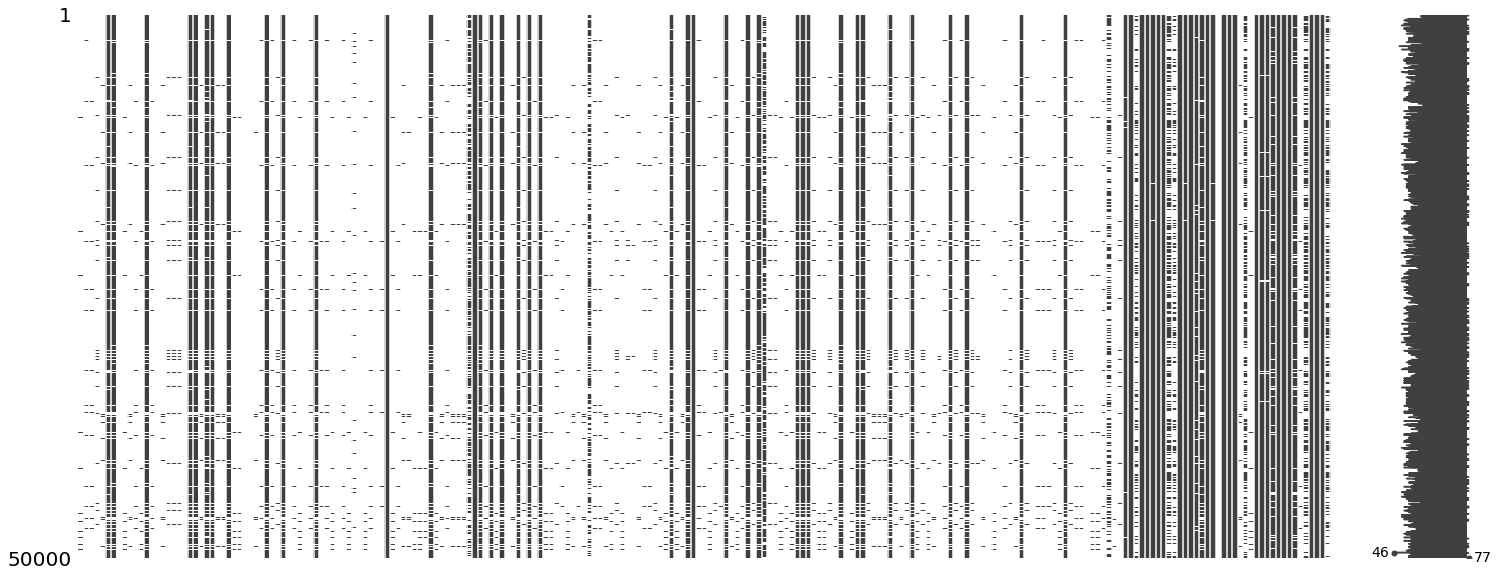

In [36]:
msn.matrix(data);

As we can see there are **a lot of missing values** - some variables are entirely non-usable, we probably will have to discard them later. There are several features (both categorical and numerical) that seem to practically not have missing values. However, it's clear that the final result will depend on the quality of the preprocessing. 

On another note, as **all features are anonimized**, it prevents from any qualitative analysis or feature generation based on common sense. Given the sheer amount of the features (mind, that this is a small dataset, original one includes 14,740 variables), it is reasonable to suggest that **all the possible features have already been generated before**, either using pairwise combinations or other available methods. Thus, we will not focus on feature engeneering in this project.

In [331]:
# Making sure that there are no features with 100% NAs:
[i  for i in data.columns if data[i].isna().sum()/len(data[i]) == 1]

['Var8',
 'Var15',
 'Var20',
 'Var31',
 'Var32',
 'Var39',
 'Var42',
 'Var48',
 'Var52',
 'Var55',
 'Var79',
 'Var141',
 'Var167',
 'Var169',
 'Var175',
 'Var185',
 'Var209',
 'Var230']

In [8]:
# Discarding empty columns:
empties = [i  for i in data.columns if data[i].isna().sum()/len(data[i]) == 1]
data.drop(empties, axis = 1, inplace=True)

Before removing variables that have almost all NAs let's take a look at wether the values they contain indicate that the person will buy our product:

In [355]:
missing_columns = [i for i in data.columns if data[i].isna().sum()/len(data[i]) >= 0.3]

for i in missing_columns:
    df = pd.DataFrame({'Percentage': data[data[i].notnull()].target.value_counts()/data[i].notnull().sum()})
    print()
    print('\n', i, 'Class imbalance:\n \n %s'% df.head())



 Var1 Class imbalance:
 
     Percentage
-1    0.974359
 1    0.025641


 Var2 Class imbalance:
 
     Percentage
-1     0.97502
 1     0.02498


 Var3 Class imbalance:
 
     Percentage
-1       0.975
 1       0.025


 Var4 Class imbalance:
 
     Percentage
-1    0.976567
 1    0.023433


 Var5 Class imbalance:
 
     Percentage
-1    0.982515
 1    0.017485


 Var9 Class imbalance:
 
     Percentage
-1    0.974359
 1    0.025641


 Var10 Class imbalance:
 
     Percentage
-1    0.982515
 1    0.017485


 Var11 Class imbalance:
 
     Percentage
-1       0.975
 1       0.025


 Var12 Class imbalance:
 
     Percentage
-1    0.971326
 1    0.028674


 Var14 Class imbalance:
 
     Percentage
-1       0.975
 1       0.025


 Var16 Class imbalance:
 
     Percentage
-1    0.982515
 1    0.017485


 Var17 Class imbalance:
 
     Percentage
-1    0.976567
 1    0.023433


 Var18 Class imbalance:
 
     Percentage
-1    0.976567
 1    0.023433


 Var19 Class imbalance:
 
     Percentage


As we can see, **amongst highly missing variables those values that are there might indicate anomaly** - the ratio is slightly more skewed towards class 1 (on average there are 1.7% of people who are likely to buy, in those variables it's 2-4%). We should not drop them. However, it would be wise to check that including those variables makes the score better indeed. Thus, in the machine learning section we will experiment with both datasets to see which one gives better performance.

In order to properly use them we should try CountEncoder later on the full dataset to see, if including those missing variables improves the performance. We also might want to **create separate features that are flags of whether this variable was missing or no** for those specific columns with high number of NAs. The underlying idea is that **a person who is prone to buying new product from us is an anomaly** (according to this dataset). So if he didn't have any particular attributes it might be a certain way to distinguish him from the mass of other people.

In [9]:
# Removing all data with NAs more than 30% - those columns can't be used in a typical way because it will purely be imputed data

columns = data.columns

counter = 0
columns_to_drop = []

for i in columns:
    if data[i].isna().sum()/len(data[i]) >= 0.3:
        print('Eliminating ...%s, percentage missing: %s %%' %(i, round(data[i].isna().sum()*100/len(data[i]), 1)))
        counter +=1
        columns_to_drop.append(i)
              
print('Totally removed %s columns' %counter)
data_cleaned = data.drop(columns_to_drop, axis = 1)

Eliminating ...Var1, percentage missing: 98.6 %
Eliminating ...Var2, percentage missing: 97.5 %
Eliminating ...Var3, percentage missing: 97.5 %
Eliminating ...Var4, percentage missing: 96.8 %
Eliminating ...Var5, percentage missing: 97.0 %
Eliminating ...Var9, percentage missing: 98.6 %
Eliminating ...Var10, percentage missing: 97.0 %
Eliminating ...Var11, percentage missing: 97.5 %
Eliminating ...Var12, percentage missing: 98.9 %
Eliminating ...Var14, percentage missing: 97.5 %
Eliminating ...Var16, percentage missing: 97.0 %
Eliminating ...Var17, percentage missing: 96.8 %
Eliminating ...Var18, percentage missing: 96.8 %
Eliminating ...Var19, percentage missing: 96.8 %
Eliminating ...Var23, percentage missing: 97.0 %
Eliminating ...Var26, percentage missing: 97.0 %
Eliminating ...Var27, percentage missing: 97.0 %
Eliminating ...Var29, percentage missing: 98.6 %
Eliminating ...Var30, percentage missing: 98.6 %
Eliminating ...Var33, percentage missing: 98.3 %
Eliminating ...Var34, perc

As we can see the majority of removed columns didn't have any values at all, they are probably no use for prediction. However, now we're left with only 68 columns. Let's check missing values there.

In [13]:
(data_cleaned.isna().sum()/data_cleaned.shape[0]).value_counts()

0.10018    20
0.00000    20
0.11078     6
0.11058     6
0.00286     3
0.14460     3
0.01406     2
0.10422     2
0.00738     1
0.00008     1
0.00002     1
0.10022     1
0.03868     1
0.27840     1
dtype: int64

We have one more variable that is almost 30% missing values, 20 with no missing values and 38 with about 10%. We will have to impute those variables. For the one that has 27.8% NAs - let's drop it too.

In [10]:
[data_cleaned.drop(i, axis = 1, inplace = True)  for i in data_cleaned.columns if data_cleaned[i].isna().sum()/data_cleaned.shape[0] > 0.25]

[None]

In [115]:
# Looking at each variable individually
data_cleaned.isna().sum()/data_cleaned.shape[0]

Var6      0.11058
Var7      0.11078
Var13     0.11078
Var21     0.11058
Var22     0.10018
Var24     0.14460
Var25     0.10018
Var28     0.10022
Var35     0.10018
Var38     0.10018
Var44     0.10018
Var57     0.00000
Var65     0.11078
Var73     0.00000
Var74     0.11078
Var76     0.10018
Var78     0.10018
Var81     0.11058
Var83     0.10018
Var85     0.10018
Var109    0.14460
Var112    0.10018
Var113    0.00000
Var119    0.11058
Var123    0.10018
Var125    0.11078
Var132    0.10018
Var133    0.10018
Var134    0.10018
Var140    0.11078
Var143    0.10018
Var144    0.11058
Var149    0.14460
Var153    0.10018
Var160    0.10018
Var163    0.10018
Var173    0.10018
Var181    0.10018
Var192    0.00738
Var193    0.00000
Var195    0.00000
Var196    0.00000
Var197    0.00286
Var198    0.00000
Var199    0.00008
Var202    0.00002
Var203    0.00286
Var204    0.00000
Var205    0.03868
Var206    0.11058
Var207    0.00000
Var208    0.00286
Var210    0.00000
Var211    0.00000
Var212    0.00000
Var216    

Let's take a look at **correlations** of the variables that are left.

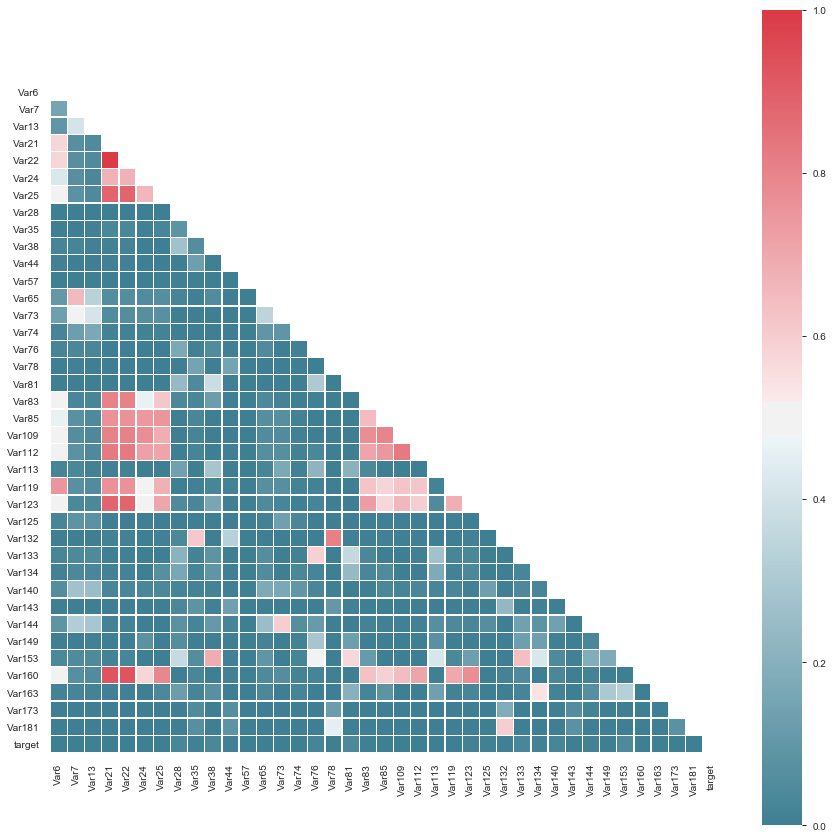

In [80]:
sns.set_style('white')
# Correlation of crimes of different types
corr_df = data_cleaned.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(corr_df, cmap = sns.diverging_palette(220, 10, as_cmap=True), vmin=0, vmax=1, linewidths=.3, square = True, mask = mask)

#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

As we can see, there are some variables that highly correlate with each other. We should consider dropping either of them not to introduce multicollinearity in the model. Another approach might be to use PCA technique to reduce the number of dimentions. Candidates for eliminating given their almost perfect correlation with some other variables:  
- `Var160`
- `Var22`
- `Var21`

In [16]:
# The correlation is extrememly high!, Var21 and Var22 are fully correlated
data_cleaned[['Var160','Var22', 'Var21', 'Var123']].corr()

,Var160,Var22,Var21,Var123
Var160,1.000000,0.927281,0.926964,0.770352
Var22,0.927281,1.000000,1.000000,0.885477
Var21,0.926964,1.000000,1.000000,0.885950
Var123,0.770352,0.885477,0.885950,1.000000


We will come back to using those flags in Machine learning section if they end up performing better then our cleaned dataset.

In [55]:
# Checking statistics of the dataset to see if it's scaled - we can see that it's not
data_cleaned.describe()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var57,Var65,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var109,Var112,Var113,Var119,Var123,Var125,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181
count,44471.000000,44461.000000,44461.000000,44471.000000,44991.000000,42770.000000,44991.000000,44989.000000,44991.000000,4.499100e+04,44991.000000,50000.000000,44461.000000,50000.00000,44461.000000,4.499100e+04,44991.000000,4.447100e+04,44991.000000,44991.000000,42770.000000,44991.000000,5.000000e+04,44471.000000,44991.000000,4.446100e+04,44991.000000,4.499100e+04,4.499100e+04,44461.000000,44991.000000,44471.000000,4.277000e+04,4.499100e+04,44991.000000,4.499100e+04,44991.000000,44991.000000
mean,1326.437116,6.809496,1249.688401,234.518225,290.245382,4.507926,96.827010,224.507669,0.716810,2.579107e+06,0.166833,3.512311,14.868896,66.64108,103.658127,1.490154e+06,0.534707,1.030841e+05,20.023560,8.461026,60.888660,66.221066,-1.532786e+05,916.112185,60.188038,2.788763e+04,3.524616,2.273572e+06,4.373404e+05,1381.259643,0.058012,11.727665,2.949208e+05,6.181967e+06,38.803005,4.860780e+05,0.006846,0.611456
std,2685.693668,6.326053,2794.954874,565.560147,704.489990,9.928819,214.318283,98.520240,2.996007,3.010076e+06,1.629344,2.025882,10.134441,52.85917,766.711978,1.853693e+06,2.135359,1.062721e+05,88.129462,20.620485,141.249202,157.637671,7.613730e+05,2165.433155,221.551302,9.012838e+04,9.994878,2.438600e+06,6.043415e+05,3990.510522,0.643061,11.720288,6.568946e+05,4.348926e+06,99.497149,8.488638e+05,0.132503,2.495681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-66.880000,0.000000,0.000000e+00,0.000000,0.000214,9.000000,4.00000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-9.803600e+06,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,518.000000,0.000000,0.000000,112.000000,135.000000,0.000000,16.000000,166.560000,0.000000,7.794000e+03,0.000000,1.743164,9.000000,24.00000,0.000000,8.936000e+04,0.000000,1.635696e+04,0.000000,0.000000,24.000000,16.000000,-1.827148e+05,425.000000,6.000000,2.340000e+02,0.000000,2.168075e+05,2.980800e+04,0.000000,0.000000,0.000000,0.000000e+00,1.232346e+06,10.000000,0.000000e+00,0.000000,0.000000
50%,861.000000,7.000000,232.000000,144.000000,180.000000,2.000000,48.000000,220.080000,0.000000,1.290246e+06,0.000000,3.514740,9.000000,52.00000,7.000000,8.820000e+05,0.000000,7.352341e+04,10.000000,4.000000,32.000000,40.000000,2.961542e+04,560.000000,30.000000,6.471000e+03,0.000000,1.479810e+06,2.089280e+05,220.000000,0.000000,9.000000,5.189800e+04,8.131560e+06,22.000000,1.346220e+05,0.000000,0.000000
75%,1428.000000,7.000000,1604.000000,228.000000,285.000000,6.000000,112.000000,266.400000,0.000000,4.570944e+06,0.000000,5.264741,18.000000,102.00000,84.000000,2.309884e+06,0.000000,1.819770e+05,25.000000,10.000000,56.000000,72.000000,1.474875e+05,895.000000,72.000000,3.161700e+04,0.000000,3.604725e+06,6.148840e+05,1350.000000,0.000000,18.000000,4.121128e+05,1.037338e+07,42.000000,6.159000e+05,0.000000,0.000000
max,131761.000000,140.000000,197872.000000,36272.000000,45340.000000,494.000000,13168.000000,5158.560000,110.000000,1.884690e+07,135.000000,7.000000,180.000000,264.00000,142156.000000,1.935360e+07,39.000000,1.814403e+06,6335.000000,1178.000000,7456.000000,10352.000000,9.932480e+06,105060.000000,13086.000000,5.436045e+06,184.000000,1.500990e+07,5.735340e+06,520545.000000,18.000000,81.000000,1.693440e+07,1.390780e+07,4862.000000,1.451520e+07,6.000000,49.000000


# 2. Looking at the target and class imbalance

The dataset is highly imbalanced, let's look at the ratio of people who didn't not buy our product when offered and those who did.

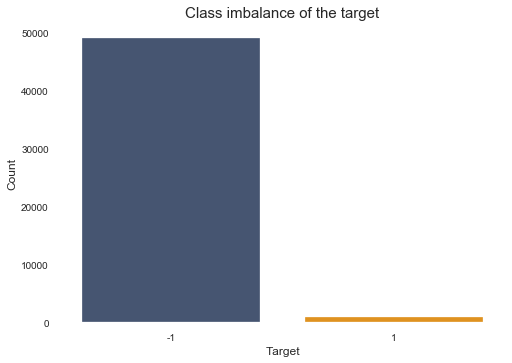

In [83]:
ax = sns.countplot(x = data_cleaned.target, palette = ['#3f5378', '#ff9800'])
ax.set_title('Class imbalance of the target', fontsize = 15)
ax.set_xlabel('Target', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12);

In [19]:
print('Total class imbalance is: %s %% negative labels to %s %% positive ones' %(round(sum(data_cleaned.target == -1)*100/len(data_cleaned.target),2), 
                                                round(sum(data_cleaned.target == 1)*100/len(data_cleaned.target),2)))

Total class imbalance is: 98.22 % negative labels to 1.78 % positive ones


In [106]:
# Calculate the weights of the class
compute_class_weight('balanced', np.unique(data_cleaned.target), data_cleaned.target)

array([ 0.50906129, 28.08988764])

**The dataset is heavily imbalanced**. This can lead to algorithms performing worse if it's not treated properly. Moreover, it's clear that **we can't use such metric as accuracy**, since it's gonna give us biased perception of the performance of the model (detecting the majority of cases where the person will not buy the new product may result in about 97% accuracy but the model might be very bad at detecting the people we are actually interested in). Thus, **extra attention should be paid to confusion matrix/Precision/Recall/F1 score/AUC**.

There are several techniques that we can apply to improve model performance with highly imbalanced data:
- Using `class_balance` parameter when running models with calculated weights of the class;  
- `Resampling`:  
    - Oversampling the minority class  
    - Undersampling the majority class (probably will perform worse since we only have 890 observations of minority class)  
- `Generating synthetic samples (SMOTE)`

In [79]:
# Using PCA to visualise the dataset
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.05, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']


transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    
    
])

X_vis_prep = transformation_pipeline.fit_transform(X_test)

In [80]:
# Using PCA to visualise the dataset
pca = PCA()
pca_components = pca.fit_transform(X_vis_prep)
pca.explained_variance_ratio_.cumsum()

array([0.70144707, 0.89666863, 0.93821328, 0.97005373, 0.98381232,
       0.9923822 , 0.99774344, 0.99966858, 0.9998812 , 0.99999932,
       0.9999996 , 0.99999971, 0.99999982, 0.99999988, 0.9999999 ,
       0.99999992, 0.99999993, 0.99999994, 0.99999995, 0.99999996,
       0.99999997, 0.99999997, 0.99999998, 0.99999998, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

We can see that first two PCA capture about 88% of the variance, which is a lot. Using a scaler resulted in worse explanatory power of the components, so I stuck without it. We can also see that a lot of columns seem to be redundant.

In [81]:
df_to_viz = pd.DataFrame({'pca_1': pca_components[:,0], 'pca_2':pca_components[:,1], 'target': y_test})

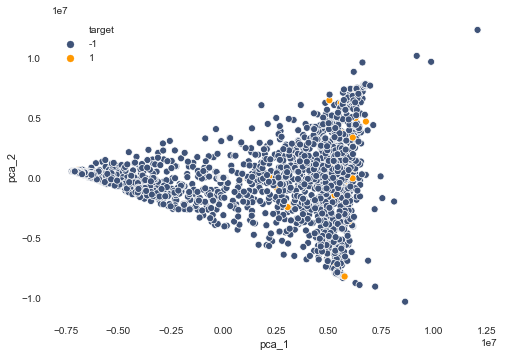

In [85]:
# The division between different targets is not stark, we can't really say that the target=1 is clustered in one region of the plot
sns.set_style('white')
sns.scatterplot(x = 'pca_1', y = 'pca_2', data = df_to_viz, hue = 'target', palette = ['#3f5378', '#ff9800']);

Given that the ratio of classes is 1:56 our positive labels represent anomaly cases. Thus, **apart from starndard machine learning classifiers we can try using special approaches for anomaly detection**. Mahalanobis distance proved to give good results in those problems since it punishes observations that are very 'odd' or different from the majority of the cases. In contrast with traditional Euclidian distance, Mahalanobis distance does not treat every dimention as equal. The Euclidean distance between a point and a distribution is given by 
z =(x – μ)/σ, where 
- x is the point in question, 
- μ is the mean and 
- σ the standard deviation of the underlying distribution.

The major problem with the approach above is in the calculation of mean and standard deviation. If we really had outliers in our data, they would definitely skew the calculation of mean and standard deviation. Remember, the outliers are points that do not belong to the real distribution.
Mhalanobis definition is very similar to the Euclidean distance, except each element of the summation is weighted by the corresponding element of the covariance matrix of the data, which helps us to deal with the above mentioned issue (For more technicall explanation see [https://nirpyresearch.com/detecting-outliers-using-mahalanobis-distance-pca-python](https://nirpyresearch.com/detecting-outliers-using-mahalanobis-distance-pca-python/) )

Thus, **PCA + Mahalanobis distance** might be a good way to detect our outliers. [https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7). Another proposed solution is using an **Autoencoder NN**.

# 3. Feature Engeneering

## 3.1 Creating flag columns for numerical variables with high number of NAs

Here we are **focusing on only numerical columns** since we will create those types of columns for categorical columns automatically. When we are using **CountEncoder() by default it treats NAs as another value** and counts the number of missing values and imputes it into every cell that was missing. Thus, categorical columns represent both frequency of existing data and frequency of the data that was not there. It is not the same as creating a flag column where 1 refers to wether the data was not there or 0 if the data was there, but theoretically, it should convey more information.

In [514]:
#missing_numerical_columns = [i for i in data.iloc[:, :189].columns if (data[i].isna().sum()/len(data[i]) >= 0.3)]

#for i in missing_numerical_columns:
    #data[i + '_flag'] = np.where(data[i].isna() == True, 1, 0)

In [595]:
# Implemented in a custom transformer in the way described in a cell above, so that we can easily drop flags if necessary:
FlagColumns(flag=True).fit_transform(data).shape

(50000, 381)

In [593]:
#Checking shape before applying transformations:
data.shape

(50000, 231)

In [596]:
# Checking columns after transformation
FlagColumns(flag=True).fit_transform(data).columns

Index(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'Var9',
       'Var10',
       ...
       'Var179_flag', 'Var180_flag', 'Var182_flag', 'Var183_flag',
       'Var184_flag', 'Var185_flag', 'Var186_flag', 'Var187_flag',
       'Var188_flag', 'Var189_flag'],
      dtype='object', length=381)

# 4. Machine Learning

## 4.1 Random Forest

### 4.1.0 Random Forest w/o PCA and resampling, baseline

Before machine learning we split the set into test and train. I prefer **stratified split** given highly imbalanced data. First, let's work with cleaned data to set the baseline and see how the resampling techniques perform.

In [330]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

Let's see the baseline Random Forest classifier on cleaned dataset first.

In [332]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()
params_grid = {'max_depth': [4, 5,7, None],
                'n_estimators': [50, 100, 200, 150], 
                'min_samples_leaf': [3, 4, 5]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 234 out of 240 | elapsed:  3.3min remaining:    5.1s
[Parallel(n_jobs=-1)]: Done 240 out 

In [333]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 200}

In [334]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  0.9822
Test performance on Random Forest w/o PCA roc_auc:  0.5
Test performance on Random Forest w/o PCA f1-score:  0.0
              precision    recall  f1-score   support

    class_-1       0.98      1.00      0.99      9822
     class_1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



/Users/ekaterina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [335]:
#Checking predictions - we had 10k observations in the test set
predictions = pd.DataFrame(y_pred)
predictions[0].value_counts()

-1    10000
Name: 0, dtype: int64

As we can see, there is a massive overfitting here. We are predicting all the observations as majority class. Let's try resampling.

### 4.1.1 Random Forest, w/o PCA, Oversampling minority class

**Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when we don’t have a a lot of data.**

It's crucial to remember that we must not conduct any resampling techniques before splitting into test and train since that allows the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

In [336]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

In [337]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
didnt_buy = X[X.target==-1]
bought = X[X.target==1]

# upsample minority
bought_upsampled = resample(bought,
                          replace=True, # sample with replacement
                          n_samples=len(didnt_buy), # match number in majority class
                          random_state=27) 

# combine majority and upsampled minority
data_upsampled = pd.concat([didnt_buy, bought_upsampled])

X_train = data_upsampled.drop('target', axis = 1)
y_train = data_upsampled.target

# check new class counts
data_upsampled.target.value_counts()

 1    39288
-1    39288
Name: target, dtype: int64

In [341]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
   
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()
params_grid = {'max_depth': [4, None, 3],
                'n_estimators': [80, 60], 
                'min_samples_leaf': [3,  2], 
              'random_state': [42]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed:   51.0s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:   53.3s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:   59.6s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   59.8s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   59.9s finished


In [342]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'n_estimators': 80,
 'random_state': 42}

In [343]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test))

print('Train performance on Random Forest with Oversampling: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest with Oversampling roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest with Oversampling f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Random Forest with Oversampling:  0.9999109142740786
Test performance on Random Forest with Oversampling roc_auc:  0.4974037874160049
Test performance on Random Forest with Oversampling f1-score:  0.0

               precision    recall  f1-score   support

    class_-1       0.98      0.99      0.99      9822
     class_1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.49     10000
weighted avg       0.96      0.98      0.97     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           9771            51
class_1             178             0


**Notes:**

**The results got even worse**. We are predicting worse than baseline and worse than random.

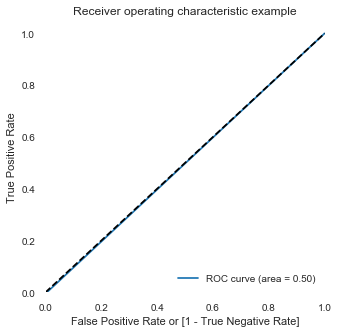

In [346]:
# Plotting roc_curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs, drop_intermediate=False)
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc_score)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate or [1 - True Negative Rate]")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return None


fpr, tpr, thresholds = roc_curve(y_test,y_pred,drop_intermediate=False)

draw_roc(y_test, y_pred)

For now, the model's **predicting power is very weak: it's close to random.**

### 4.1.2 Random Forest, w/o PCA, Undersampling majority class

**Undersampling is removing some observations of the majority class. Undersampling can be a good choice when we have a lot of data**. But a crucial drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set. 

We will still be using the separate classes from the previous oversampling exercise.

In [344]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

In [345]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# downsample majority
didnt_buy_downsampled = resample(didnt_buy,
                                replace = False, # sample without replacement
                                n_samples = len(bought), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([didnt_buy_downsampled, bought])

# checking counts
data_downsampled.target.value_counts()

X_train = data_downsampled.drop('target', axis = 1)
y_train = data_downsampled.target

# check new class counts
data_downsampled.target.value_counts()

 1    712
-1    712
Name: target, dtype: int64

In [347]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()

params_grid = {'max_depth': [15, 17, 10],
                'n_estimators': [53, 55,49], 
                'min_samples_leaf': [25,15, 20], 
              'random_state': [42, 27]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1483s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 267 out of 270 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    3.8s finished


In [348]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 20,
 'n_estimators': 55,
 'random_state': 42}

In [349]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test))

print('Train performance on Random Forest with Undersampling: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest with Undersampling roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest with Undersampling f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Random Forest with Undersampling:  0.776685393258427
Test performance on Random Forest with Undersampling roc_auc:  0.7016815038013722
Test performance on Random Forest with Undersampling f1-score:  0.07579826917338107

               precision    recall  f1-score   support

    class_-1       0.99      0.69      0.81      9822
     class_1       0.04      0.71      0.08       178

    accuracy                           0.69     10000
   macro avg       0.52      0.70      0.44     10000
weighted avg       0.98      0.69      0.80     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           6776          3046
class_1              51           127


**The results are way better than with oversampling!** We can see improvements: now we are predicting that some clients will buy our product. As can be seen from confusion matrix, **we are making a lot of errors though, specifically in False Positives**. Those customers refer to the people who could be assigned as leads by the model and then pursued by marketing department but didn't end up churning despite all the spendings. Thus, we should keep in mind that this number should be as low as possible since it's direct incurred expenditures, whereas those False Negatives refer to the people who we din't spot at the moment but they churned anyway. However, this is a huge improvement from the baseline 0.5 AUC.

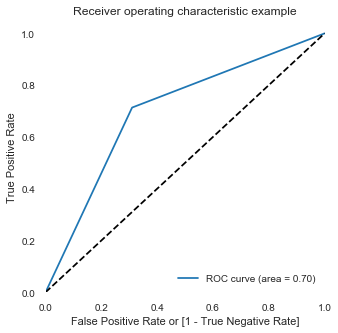

In [350]:
draw_roc(y_test, y_pred)

### 4.1.3 Random Forest, w/o PCA, SMOTE

A technique similar to upsampling is SMOTE (Synthetic Minority Oversampling Technique). **SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model**.
Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [375]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

In [376]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

In [377]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '-1': {} \n".format(sum(y_train==-1)))

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_prep_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_sm.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_sm==1)))
print("After OverSampling, counts of label '-1': {}".format(sum(y_train_sm==-1)))

Before OverSampling, counts of label '1': 712
Before OverSampling, counts of label '-1': 39288 

After OverSampling, the shape of train_X: (78576, 66)
After OverSampling, the shape of train_y: (78576,) 

After OverSampling, counts of label '1': 39288
After OverSampling, counts of label '-1': 39288


In [378]:
rf = RandomForestClassifier()
params_grid = {'max_depth': [None, 10],
                'n_estimators': [200,300], 
                'min_samples_leaf': [3,4], 
              'random_state': [901]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:  2.6min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:  2.9min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:  3.9min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:  4.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:  4.4min remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.9min finished


In [379]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'n_estimators': 300,
 'random_state': 901}

In [380]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test))

print('Train performance on Random Forest, SMOTE, w/o PCA: ',  grid_rf.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest, SMOTE, w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest, SMOTE, w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Random Forest, SMOTE, w/o PCA:  0.9985619018529831
Test performance on Random Forest, SMOTE, w/o PCA roc_auc:  0.5022490213439675
Test performance on Random Forest, SMOTE, w/o PCA f1-score:  0.010526315789473684

               precision    recall  f1-score   support

    class_-1       0.98      1.00      0.99      9822
     class_1       0.08      0.01      0.01       178

    accuracy                           0.98     10000
   macro avg       0.53      0.50      0.50     10000
weighted avg       0.97      0.98      0.97     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           9811            11
class_1             177             1


We can see that **SMOTE deals with imbalancing better than oversampling but way worse than undersampling**. Precision and recall are still very low, we're close to random.

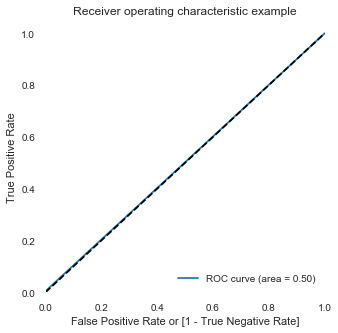

In [381]:
#Roc curve
draw_roc(y_test, y_pred)

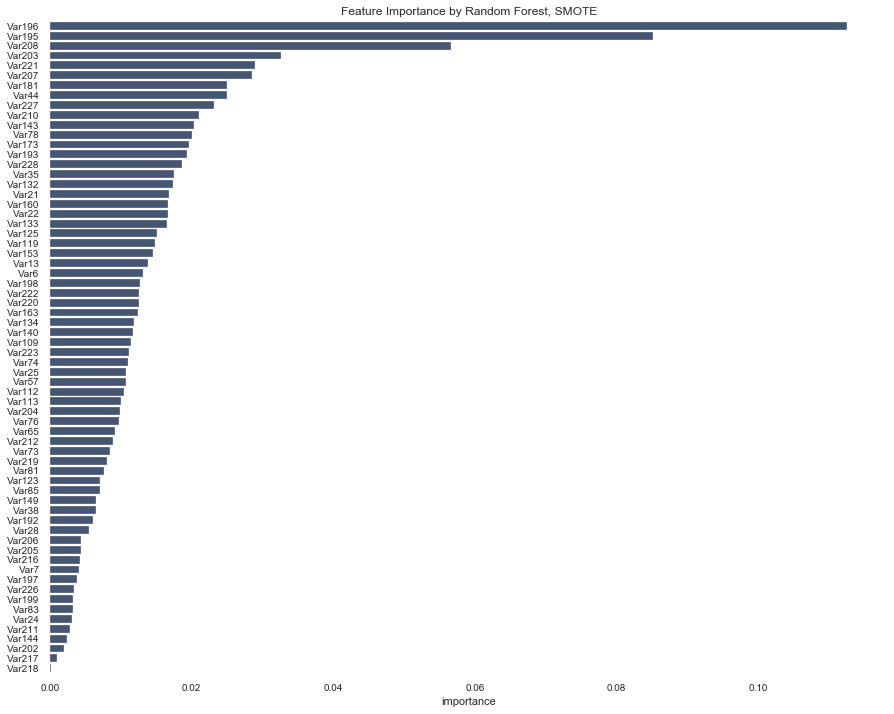

In [382]:
# Feature Importance
feature_names = data_cleaned.drop('target', axis = 1).columns
feature_importance = pd.DataFrame({'importance': grid_rf.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(15,12))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#3f5378'])
plt.title('Feature Importance by Random Forest, SMOTE');

As we can see resampling techniques can make a massive difference. Now, let's experiment with PCA, feature generation, scalers and encoders. Finally, let's try different classifiers.

### 4.1.4 Random Forest with undersampling, PCA

In [526]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
didnt_buy = X[X.target==-1]
bought = X[X.target==1]

# downsample majority
didnt_buy_downsampled = resample(didnt_buy,
                                replace = False, # sample without replacement
                                n_samples = len(bought), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([didnt_buy_downsampled, bought])

# checking counts
data_downsampled.target.value_counts()

X_train = data_downsampled.drop('target', axis = 1)
y_train = data_downsampled.target

transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

In [527]:
# Choosing number of components
pca = PCA()
pca.fit(X_train_prep)
pca.explained_variance_ratio_.cumsum()

array([0.63089289, 0.86747858, 0.92851011, 0.96858099, 0.9845902 ,
       0.99179176, 0.99797625, 0.99946589, 0.9998687 , 0.99999927,
       0.99999955, 0.99999977, 0.99999992, 0.99999994, 0.99999996,
       0.99999997, 0.99999997, 0.99999998, 0.99999998, 0.99999998,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

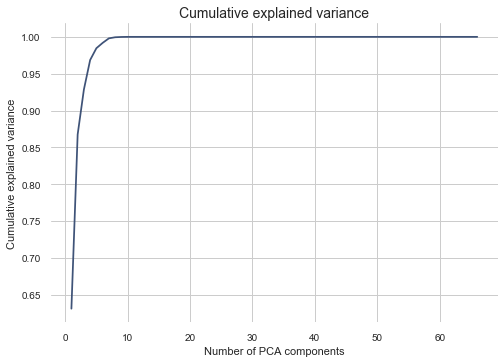

In [484]:
# Best number of pcas is 8-9
sns.set_style('whitegrid')
sns.lineplot(x = range(1,67), y= pca.explained_variance_ratio_.cumsum(), color = '#3f5378')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance', fontsize = 14);

In [534]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
     ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9)), 
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()
params_grid = {'max_depth': [None],
                'n_estimators': [300, 250, 270], 
                'min_samples_leaf': [2,4, 100, 150, 200], 
              'random_state': [42, 901]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 135 out of 150 | elapsed:    9.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   10.4s finished


In [536]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 150,
 'n_estimators': 250,
 'random_state': 901}

In [537]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test))

print('Train performance on Random Forest, Undersampling, with PCA: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest, Undersampling, wtih PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest, Undersampling, with PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Random Forest, Undersampling, with PCA:  0.6573033707865169
Test performance on Random Forest, Undersampling, wtih PCA roc_auc:  0.6553683659018164
Test performance on Random Forest, Undersampling, with PCA f1-score:  0.06880882830249918

               precision    recall  f1-score   support

    class_-1       0.99      0.72      0.83      9822
     class_1       0.04      0.60      0.07       178

    accuracy                           0.71     10000
   macro avg       0.51      0.66      0.45     10000
weighted avg       0.97      0.71      0.82     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           7025          2797
class_1              72           106


**Notes:**  
PCA here performs worse.

### 4.1.5 Random Forest with undersampling, full dataset with NA columns and no flag columns

In [538]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["target"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train_full = strat_train.drop('target', axis = 1)
X_test_full = strat_test.drop('target', axis = 1)

y_train_full = strat_train['target']
y_test_full = strat_test['target']

# concatenate our training data back together
X = pd.concat([X_train_full, y_train_full], axis=1)

# separate minority and majority classes
didnt_buy = X[X.target==-1]
bought = X[X.target==1]

# downsample majority
didnt_buy_downsampled = resample(didnt_buy,
                                replace = False, # sample without replacement
                                n_samples = len(bought), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([didnt_buy_downsampled, bought])

# checking counts
data_downsampled.target.value_counts()

X_train = data_downsampled.drop('target', axis = 1)
y_train = data_downsampled.target

transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

In [539]:
rf = RandomForestClassifier()
params_grid = {'max_depth': [None],
                'n_estimators': [100,80, 150, 200, 230], 
                'min_samples_leaf': [20, 40, 30, 10], 
              'random_state': [42, 901]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 190 out of 200 | elapsed:    7.8s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.2s finished


In [540]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 20,
 'n_estimators': 200,
 'random_state': 42}

In [541]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on  Random Forest with Undersampling, full_dataset, no flags: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on  Random Forest with Undersampling, full_dataset, no flags roc_auc: ',roc_auc_score(y_test_full, y_pred))
print('Test performance on  Random Forest with Undersampling, full_dataset, no flags f1-score: ', f1_score(y_test_full, y_pred))


target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on  Random Forest with Undersampling, full_dataset, no flags:  0.8103932584269663
Test performance on  Random Forest with Undersampling, full_dataset, no flags roc_auc:  0.749019056051652
Test performance on  Random Forest with Undersampling, full_dataset, no flags f1-score:  0.09770540340488527

               precision    recall  f1-score   support

    class_-1       0.99      0.76      0.86      9822
     class_1       0.05      0.74      0.10       178

    accuracy                           0.76     10000
   macro avg       0.52      0.75      0.48     10000
weighted avg       0.98      0.76      0.85     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           7430          2392
class_1              46           132


**Notes:**  
**The best results so far!** Full dataset performs better than cleaned one without feautures with a lot of NAs.

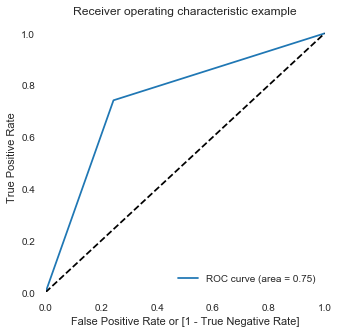

In [448]:
#Roc curve
draw_roc(y_test, y_pred)

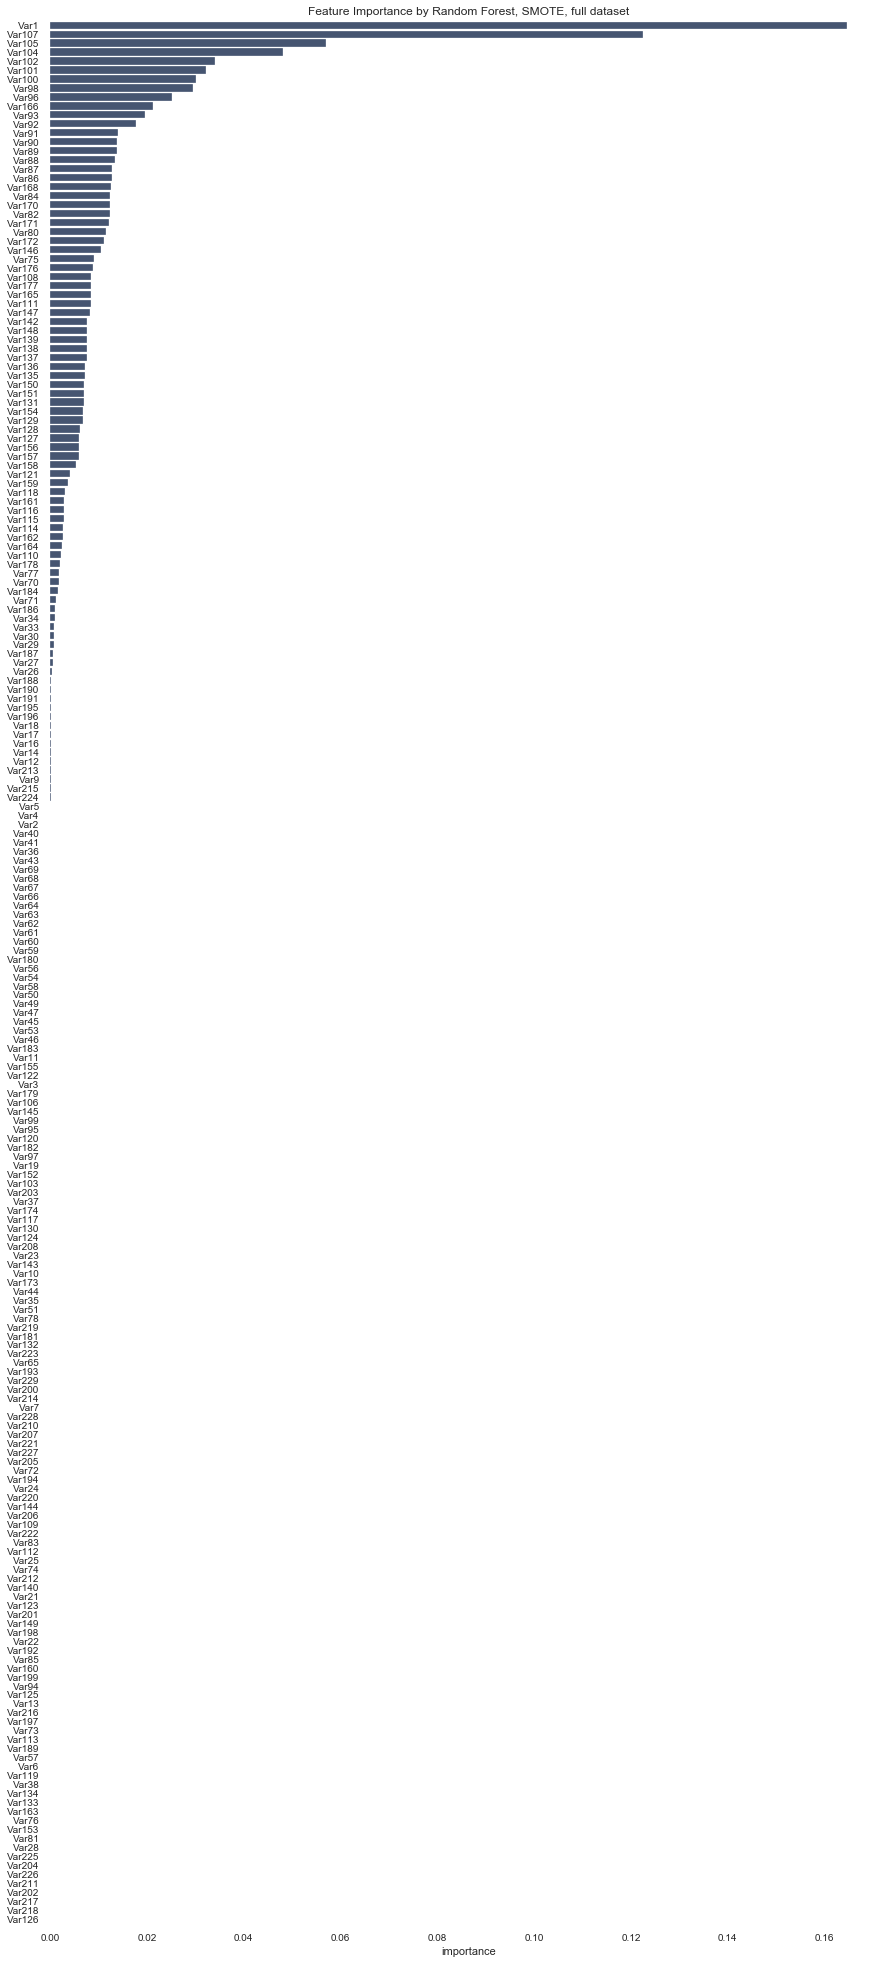

In [542]:
# Feature Importance
feature_names = data.drop('target', axis = 1).columns
feature_importance = pd.DataFrame({'importance': grid_rf.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(15,35))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#3f5378'])
plt.title('Feature Importance by Random Forest, SMOTE, full dataset');

**Notes**:  

As we can see there are a lot of variables that seem to be not significant at all. Let's try to do feature selection and see if performance increases.

In [550]:
# Zero feature importance
zero_import = feature_importance[feature_importance.importance >0].index
zero_import

Index(['Var182', 'Var114', 'Var122', 'Var166', 'Var172', 'Var34', 'Var183',
       'Var3', 'Var139', 'Var208', 'Var127', 'Var148', 'Var174', 'Var46',
       'Var106', 'Var143', 'Var120', 'Var171', 'Var161', 'Var195', 'Var68',
       'Var60', 'Var173', 'Var181', 'Var117', 'Var221', 'Var170', 'Var36',
       'Var203', 'Var207', 'Var35', 'Var214', 'Var200', 'Var210', 'Var227',
       'Var51', 'Var162', 'Var193', 'Var228', 'Var132', 'Var44', 'Var78',
       'Var194', 'Var7', 'Var223', 'Var201', 'Var229', 'Var65', 'Var220',
       'Var144', 'Var219', 'Var85', 'Var212', 'Var24', 'Var222', 'Var72',
       'Var198', 'Var206', 'Var25', 'Var83', 'Var112', 'Var123', 'Var140',
       'Var205', 'Var21', 'Var22', 'Var211', 'Var109', 'Var163', 'Var160',
       'Var149', 'Var94', 'Var38', 'Var13', 'Var125', 'Var199', 'Var76',
       'Var192', 'Var189', 'Var216', 'Var74', 'Var6', 'Var197', 'Var134',
       'Var204', 'Var28', 'Var73', 'Var202', 'Var133', 'Var57', 'Var119',
       'Var153', 'Var225', 'Va

In [558]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown ='0')),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])
X_train_imp = X_train.drop(zero_import, axis = 1)
X_train_prep = transformation_pipeline.fit_transform(X_train_imp)

In [571]:
rf = RandomForestClassifier()
params_grid = {'max_depth': [None],
                'n_estimators': [12,80, 50, 30], 
                'min_samples_leaf': [3,10, 5], 
              'random_state': [42, 901]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0454s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  89 out of 120 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 102 out of 120 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.3s finished


In [572]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'n_estimators': 12,
 'random_state': 901}

In [573]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.transform(X_test_full.drop(zero_import, axis = 1)))

print('Train performance on  Random Forest with Undersampling, full_dataset, no flags: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on  Random Forest with Undersampling, full_dataset, no flags roc_auc: ',roc_auc_score(y_test_full, y_pred))
print('Test performance on  Random Forest with Undersampling, full_dataset, no flags f1-score: ', f1_score(y_test_full, y_pred))


target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on  Random Forest with Undersampling, full_dataset, no flags:  0.5470505617977528
Test performance on  Random Forest with Undersampling, full_dataset, no flags roc_auc:  0.5109293743236349
Test performance on  Random Forest with Undersampling, full_dataset, no flags f1-score:  0.03722084367245657

               precision    recall  f1-score   support

    class_-1       0.98      0.94      0.96      9822
     class_1       0.02      0.08      0.04       178

    accuracy                           0.92     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.97      0.92      0.94     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           9209           613
class_1             163            15


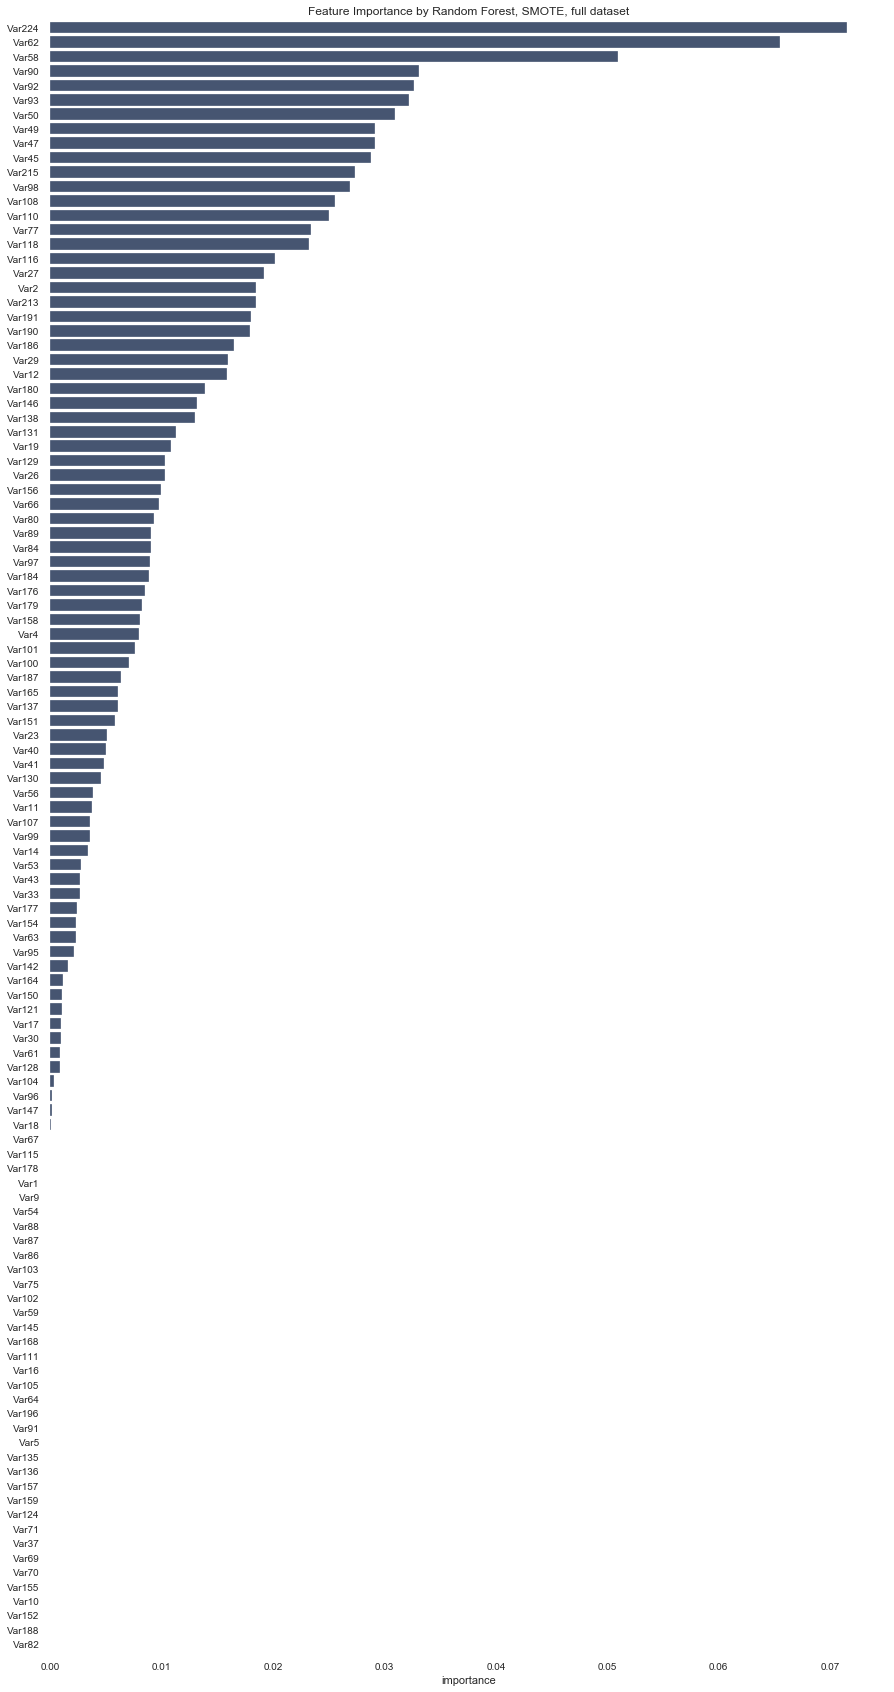

In [579]:
# Feature Importance
feature_names = X_test_full.drop(zero_import, axis = 1).columns
feature_importance = pd.DataFrame({'importance': grid_rf.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(15,30))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#3f5378'])
plt.title('Feature Importance by Random Forest, SMOTE, full dataset');

**Notes**:  

Performance is a way worse if we're dropping the features. However, having all the columns gives us the best results.

### 4.1.6 Random Forest with Undersampling, full dataset and flags

In [584]:
transformation_pipeline = Pipeline([
    ('flags', FlagColumns()),
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()), 
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()
params_grid = {'max_depth': [None],
                'n_estimators': [80, 250 ,150, 200], 
                'min_samples_leaf': [3,10,50, 30], 
              'random_state': [42, 901]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [585]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 3,
 'n_estimators': 200,
 'random_state': 901}

In [587]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.fit_transform(X_test_full))

print('Train performance on Random Forest with flags: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest with flags roc_auc: ',roc_auc_score(y_test_full, y_pred))
print('Test performance on Random Forest with flags f1-score: ', f1_score(y_test_full, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Random Forest with flags:  0.985252808988764
Test performance on Random Forest with flags roc_auc:  0.7058638140931044
Test performance on Random Forest with flags f1-score:  0.07050469185899061

               precision    recall  f1-score   support

    class_-1       0.99      0.63      0.77      9822
     class_1       0.04      0.78      0.07       178

    accuracy                           0.63     10000
   macro avg       0.52      0.71      0.42     10000
weighted avg       0.98      0.63      0.76     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           6196          3626
class_1              39           139


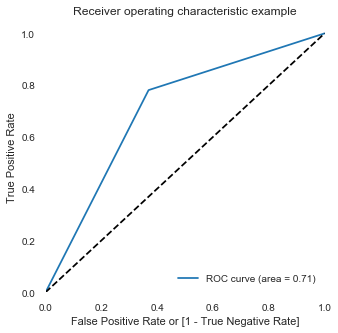

In [588]:
#Roc curve
draw_roc(y_test_full, y_pred)

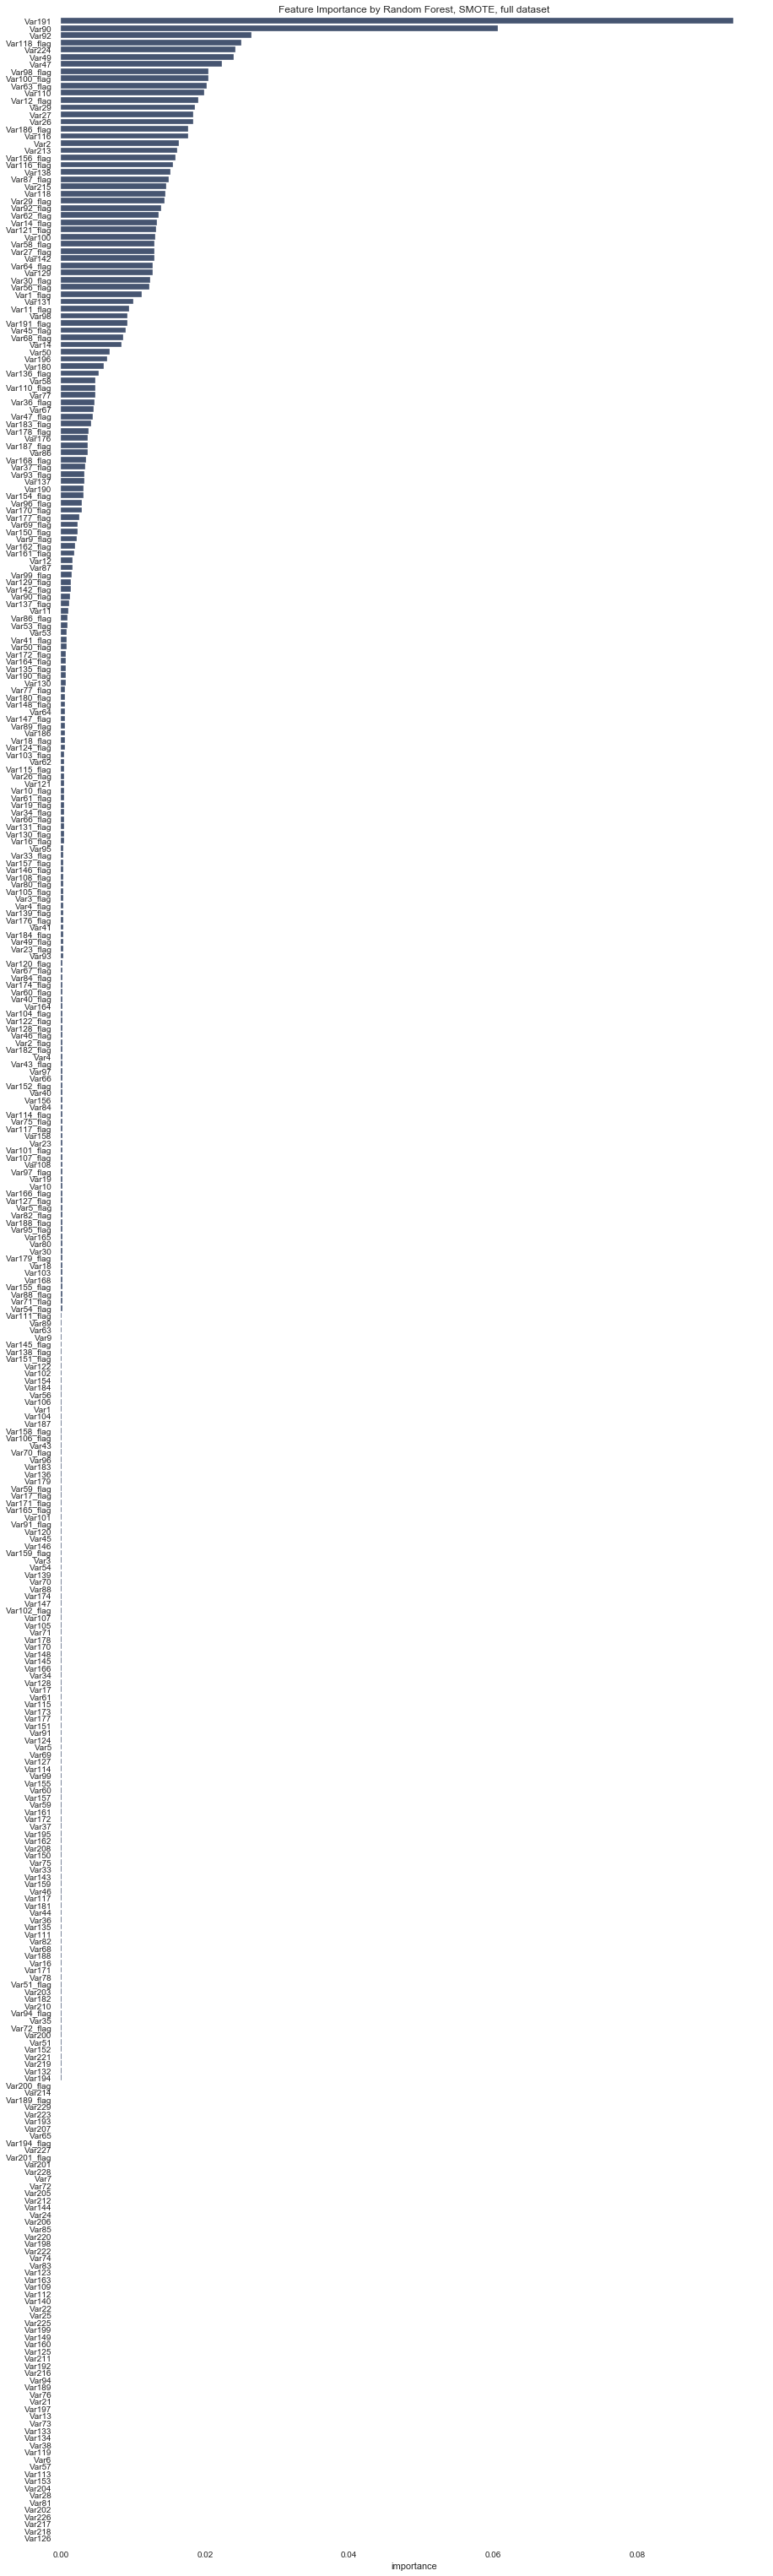

In [589]:
# Feature Importance
feature_names =  FlagColumns().fit_transform(X_train_full).columns
feature_importance = pd.DataFrame({'importance': grid_rf.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(15,55))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#3f5378'])
plt.title('Feature Importance by Random Forest, SMOTE, full dataset');

**Notes:**

The best results for RF classifier. We can see that flagged variables proved to be very important for this algorithm. However, AUC is higher without flags. Let's try another classifier.

## 4.2 Logistic Regression

### 4.2.1 Logistic regression with SMOTE, full dataset with NA columns and no flag columns

In [357]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["target"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train_full = strat_train.drop('target', axis = 1)
X_test_full = strat_test.drop('target', axis = 1)

y_train_full = strat_train['target']
y_test_full = strat_test['target']

In [358]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()), 
])

X_train_prep = transformation_pipeline.fit_transform(X_train_full)

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train_full)



params_grid = {
    'C': [15, 20, 10],
    'random_state': [42, 901]
    }

logit = LogisticRegression()
grid_logit = GridSearchCV(logit, param_grid = params_grid, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1).fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   20.5s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   20.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   22.5s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   23.2s remaining:   23.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   39.6s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   39.9s remaining:   12.1s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   40.7s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   40.8s finished
/Users/ekaterina/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://

In [359]:
# Getting best parameters
grid_logit.best_params_

{'C': 10, 'random_state': 42}

In [360]:
y_pred = grid_logit.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on  Logistic Regression with SMOTE, full_dataset, no flags: ',  grid_logit.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on  Logistic Regression with SMOTE, full_dataset, no flags roc_auc: ',roc_auc_score(y_test_full, y_pred))
print('Test performance on  Logistic Regression with SMOTE, full_dataset, no flags f1-score: ', f1_score(y_test_full, y_pred))


target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on  Logistic Regression with SMOTE, full_dataset, no flags:  0.781090918346569
Test performance on  Logistic Regression with SMOTE, full_dataset, no flags roc_auc:  0.7333216649621693
Test performance on  Logistic Regression with SMOTE, full_dataset, no flags f1-score:  0.08971704623878536

               precision    recall  f1-score   support

    class_-1       0.99      0.74      0.85      9822
     class_1       0.05      0.73      0.09       178

    accuracy                           0.74     10000
   macro avg       0.52      0.73      0.47     10000
weighted avg       0.98      0.74      0.83     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           7232          2590
class_1              48           130


**Notes:**

The results are close to the best Random Forest. Keeping those features was worth it!

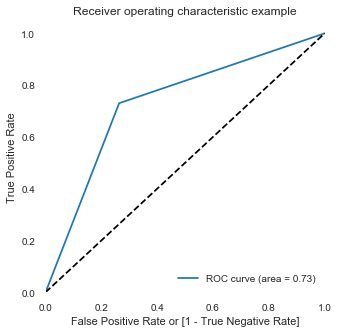

In [361]:
#Roc curve
draw_roc(y_test, y_pred)

In [ ]:
print('Precision: %s' %precision_score(y_test, y_pred))
print('Recall: %s' %recall_score(y_test, y_pred))

### 4.2.2 Logistic regression with Undersampling, PCA, full dataset, no flags

In [595]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["target"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train_full = strat_train.drop('target', axis = 1)
X_test_full = strat_test.drop('target', axis = 1)

y_train_full = strat_train['target']
y_test_full = strat_test['target']

# concatenate our training data back together
X = pd.concat([X_train_full, y_train_full], axis=1)

# separate minority and majority classes
didnt_buy = X[X.target==-1]
bought = X[X.target==1]

# downsample majority
didnt_buy_downsampled = resample(didnt_buy,
                                replace = False, # sample without replacement
                                n_samples = len(bought), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([didnt_buy_downsampled, bought])

# checking counts
data_downsampled.target.value_counts()

X_train = data_downsampled.drop('target', axis = 1)
y_train = data_downsampled.target

In [596]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
     ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9)), 
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

params_grid = {
    'C': [1, 0.1, 0.01, 10, 0.001],
    'random_state': [42, 901]
    }

logit = LogisticRegression()
grid_logit = GridSearchCV(logit, param_grid = params_grid, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1).fit(X_train_prep, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


In [597]:
# Getting best parameters
grid_logit.best_params_

{'C': 1, 'random_state': 42}

In [598]:
y_pred = grid_logit.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on Logistic Regression with PCA, SMOTE: ',  grid_logit.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Logistic Regression with PCA, SMOTE roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance oon Logistic Regression with PCA, SMOTE f1-score: ', f1_score(y_test, y_pred))


target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Logistic Regression with PCA, SMOTE:  0.5540730337078652
Test performance on Logistic Regression with PCA, SMOTE roc_auc:  0.5408610342752683
Test performance oon Logistic Regression with PCA, SMOTE f1-score:  0.03941055517477724

               precision    recall  f1-score   support

    class_-1       0.99      0.44      0.60      9822
     class_1       0.02      0.65      0.04       178

    accuracy                           0.44     10000
   macro avg       0.50      0.54      0.32     10000
weighted avg       0.97      0.44      0.59     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           4279          5543
class_1              63           115


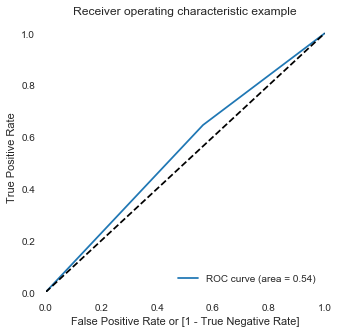

In [599]:
#Roc curve
draw_roc(y_test, y_pred)

**Notes:**

Performance is way worse with PCA.

### 4.2.3 Logistic regression with Undersampling, full dataset and flags

In [600]:
transformation_pipeline = Pipeline([
    ('flags', FlagColumns()),
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()), 
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

params_grid = {
    'C': [1, 0.1, 0.01, 10, 0.001],
    'random_state': [42, 901]
    }

logit = LogisticRegression()
grid_logit = GridSearchCV(logit, param_grid = params_grid, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1).fit(X_train_prep, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1187s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished


In [601]:
# Getting best parameters
grid_logit.best_params_

{'C': 0.01, 'random_state': 42}

In [604]:
y_pred = grid_logit.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on Logit with flags: ',  grid_logit.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Logit with flags roc_auc: ',roc_auc_score(y_test_full, y_pred))
print('Test performance on Logit with flags f1-score: ', f1_score(y_test_full, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on Logit with flags:  0.7626404494382022
Test performance on Logit with flags roc_auc:  0.7345188169644388
Test performance on Logit with flags f1-score:  0.07866703086588364

               precision    recall  f1-score   support

    class_-1       0.99      0.66      0.79      9822
     class_1       0.04      0.81      0.08       178

    accuracy                           0.66     10000
   macro avg       0.52      0.73      0.44     10000
weighted avg       0.98      0.66      0.78     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           6483          3339
class_1              34           144


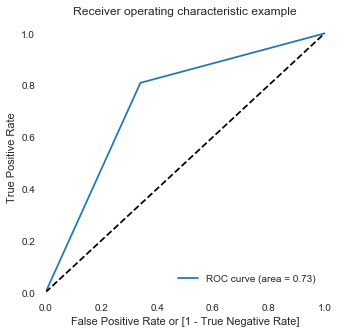

In [606]:
#Roc curve
draw_roc(y_test_full, y_pred)

**Notes:**

The performance is better with flags on the contrary Random Forest classifier.

## 4.3 LGBM

### 4.3.1 LGBM (Undersampling, full dataset, no flags)

In [613]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

lgb_params ={ "objective" : ["binary"],
    "metric" : ["auc"],
    "max_depth" : [-1],
    "num_leaves" : [150, 100, 200],
    "learning_rate" : [0.1, 0.01],
    #"bagging_freq": [2,5],
   # "bagging_fraction" : 0.4,
    #"feature_fraction" : 0.05,
    "min_data_in_leaf": [30,35],
    "lambda_l1" : [20,30, 25],
    "random_state": [42]} 
lgb_clf = lgb.LGBMClassifier()
grid_lgb = GridSearchCV(lgb_clf, param_grid = lgb_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1454s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.3s finished


In [614]:
# Getting best parameters
grid_lgb.best_params_

{'lambda_l1': 20,
 'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 35,
 'num_leaves': 150,
 'objective': 'binary',
 'random_state': 42}

In [615]:
y_pred = grid_lgb.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on LGBM with Undersampling, full dataset: ',  grid_lgb.best_estimator_.score(X_train_prep, y_train))
print('Test performance on LGBM with Undersampling, full dataset roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on LGBM with Undersampling, full dataset f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on LGBM with Undersampling, full dataset:  0.7773876404494382
Test performance on LGBM with Undersampling, full dataset roc_auc:  0.7562202713925859
Test performance on LGBM with Undersampling, full dataset f1-score:  0.10785953177257525
              precision    recall  f1-score   support

    class_-1       0.99      0.79      0.88      9822
     class_1       0.06      0.72      0.11       178

    accuracy                           0.79     10000
   macro avg       0.53      0.76      0.49     10000
weighted avg       0.98      0.79      0.87     10000



**Notes:**

Performance is better than previous classifiers!

### 4.3.2 LGBM (Undersampling, full dataset, flags)

In [616]:
transformation_pipeline = Pipeline([
    ('flags', FlagColumns()),
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

lgb_params ={ "objective" : ["binary"],
    "metric" : ["auc"],
    "max_depth" : [-1],
    "num_leaves" : [150, 100, 200],
    "learning_rate" : [0.1, 0.01],
    #"bagging_freq": [2,5],
   # "bagging_fraction" : 0.4,
    #"feature_fraction" : 0.05,
    "min_data_in_leaf": [30,35],
    "lambda_l1" : [20,30, 25],
    "random_state": [42]} 
lgb_clf = lgb.LGBMClassifier()
grid_lgb = GridSearchCV(lgb_clf, param_grid = lgb_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1450s.) Setting batch_size=2.
/Users/ekaterina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 149 out of 180 | elapsed:    2.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 168 o

In [617]:
# Getting best parameters
grid_lgb.best_params_

{'lambda_l1': 20,
 'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 35,
 'num_leaves': 150,
 'objective': 'binary',
 'random_state': 42}

In [623]:
y_pred = grid_lgb.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on LGBM with Undersampling, full dataset with flags: ',  grid_lgb.best_estimator_.score(X_train_prep, y_train))
print('Test performance on LGBM with Undersampling, full dataset with flags roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on LGBM with UndersamplingE, full dataset with flags f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on LGBM with Undersampling, full dataset with flags:  0.7773876404494382
Test performance on LGBM with Undersampling, full dataset with flags roc_auc:  0.7562202713925859
Test performance on LGBM with UndersamplingE, full dataset with flags f1-score:  0.10785953177257525

               precision    recall  f1-score   support

    class_-1       0.99      0.79      0.88      9822
     class_1       0.06      0.72      0.11       178

    accuracy                           0.79     10000
   macro avg       0.53      0.76      0.49     10000
weighted avg       0.98      0.79      0.87     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           7737          2085
class_1              49           129


**Notes:**

Performance is the same with flags.

## 4.4 XGBoost (Undersampling, full dataset, no flags)

In [625]:
# Trying on the full dataset

transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)


xgb_params ={ 'max_depth': [20, 40, -1],
    'learning_rate': [0.1,0.01],   
    "random_state": [901]} 
xgb_clf = xgb.XGBClassifier()
grid_xgb = GridSearchCV(xgb_clf, param_grid = xgb_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1220s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    0.2s remaining:    1.9s
/Users/ekaterina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    7.7s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    7.8s remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.9s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    8.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    9.6s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   13.3s 

In [626]:
# Getting best parameters
grid_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 20, 'random_state': 901}

In [627]:
y_pred = grid_xgb.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on XGBoost: ',  grid_xgb.best_estimator_.score(X_train_prep, y_train))
print('Test performance on XGBoost roc_auc: ',roc_auc_score(y_test_full, y_pred))
print('Test performance on XGBoost f1-score: ', f1_score(y_test_full, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on XGBoost:  1.0
Test performance on XGBoost roc_auc:  0.7462975800713372
Test performance on XGBoost f1-score:  0.09233926128590972

               precision    recall  f1-score   support

    class_-1       0.99      0.73      0.84      9822
     class_1       0.05      0.76      0.09       178

    accuracy                           0.73     10000
   macro avg       0.52      0.75      0.47     10000
weighted avg       0.98      0.73      0.83     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           7211          2611
class_1              43           135


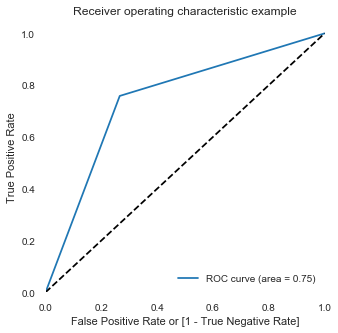

In [622]:
#Roc curve
draw_roc(y_test, y_pred)

**Notes:**

A bit worse than LGBM.

## 5.5 CatBoost

In [ ]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

cat_params ={ "loss_function": ["Logloss"],
                           "eval_metric": ["AUC"],
                           "learning_rate" : [0.01],
                           "iterations" :[7000, 30000],
                            "l2_leaf_reg" : [50],
                           "random_seed": [42],
                           "od_type": ["Iter"],
                           "depth": [5, 20]}
cat_clf = cb.CatBoostClassifier()
grid_cat = GridSearchCV(cat_clf, param_grid = cat_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep, y_train)

In [629]:
# Getting best parameters
grid_cat.best_params_

{'depth': 5,
 'eval_metric': 'AUC',
 'iterations': 7000,
 'l2_leaf_reg': 50,
 'learning_rate': 0.01,
 'loss_function': 'Logloss',
 'od_type': 'Iter',
 'random_seed': 42}

In [631]:
y_pred = grid_cat.best_estimator_.predict(transformation_pipeline.transform(X_test_full))

print('Train performance on CatBoost without flags: ',  grid_cat.best_estimator_.score(X_train_prep, y_train))
print('Test performance on CatBoost without flags roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on CatBoost without flags f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print('\n',classification_report(y_test_full, y_pred, target_names=target_names))
print('Confusion matrix: \n')
print(pd.DataFrame(confusion_matrix(y_test_full, y_pred),
                 columns=['pred_class_-1', 'pred_class_1'], index=['class_-1', 'class_1']))

Train performance on CatBoost without flags:  0.9943820224719101
Test performance on CatBoost without flags roc_auc:  0.7565714664854637
Test performance on CatBoost without flags f1-score:  0.10052513128282071

               precision    recall  f1-score   support

    class_-1       0.99      0.76      0.86      9822
     class_1       0.05      0.75      0.10       178

    accuracy                           0.76     10000
   macro avg       0.52      0.76      0.48     10000
weighted avg       0.98      0.76      0.85     10000

Confusion matrix: 

          pred_class_-1  pred_class_1
class_-1           7468          2354
class_1              44           134


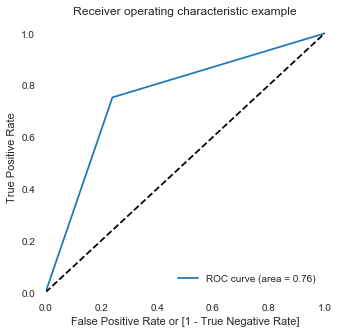

In [632]:
#Roc curve
draw_roc(y_test, y_pred)

**Notes:**

CatBoost got the best performance.

## 5.6 Mahalanobis distance

In [642]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["target"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

In [643]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])
X_train_prep = transformation_pipeline.fit_transform(X_train)

In [644]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = EmpiricalCovariance().fit(X_train_prep)
# Get the Mahalanobis distance
m_train = robust_cov.mahalanobis(X_train_prep)

mahal_dist_train = pd.DataFrame({'label': y_train, 'mahal_dist':m_train})

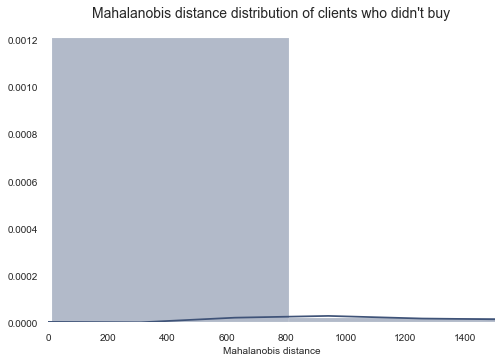

In [645]:
sns.distplot(mahal_dist_train[mahal_dist_train['label'] == -1].mahal_dist, color = '#3f5378')
plt.xlim(0,1500)
plt.title('Mahalanobis distance distribution of clients who didn\'t buy', fontsize = 14)
plt.xlabel('Mahalanobis distance', fontsize = 10);

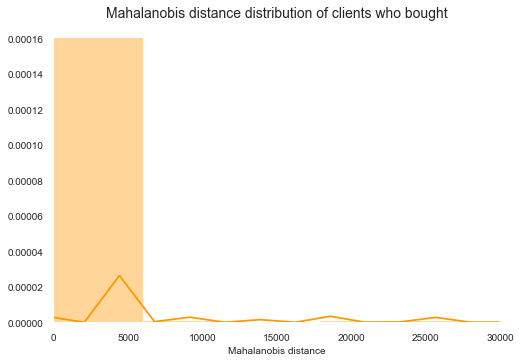

In [646]:
sns.distplot(mahal_dist[mahal_dist['label'] == 1].mahal_dist, color = '#ff9800')
plt.xlim(0,30000)
plt.title('Mahalanobis distance distribution of clients who bought', fontsize = 14)
plt.xlabel('Mahalanobis distance', fontsize = 10);

We can see that people who didn't buy from us have mahalanobis distance under 800 whereas the distance of those who didn't buy lies in the range of 0 to 30k. We can assign those observations with Mahalanobis distance more than 800 to anomaly cases and check the metrics. However, we should be mindful that there is an overlap between distributions and the results might not be as good.

In [648]:
X_test_prep = transformation_pipeline.transform(X_test)

# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = EmpiricalCovariance().fit(X_test_prep)
# Get the Mahalanobis distance
m_test = robust_cov.mahalanobis(X_test_prep)

mahal_dist_test = pd.DataFrame({'label': y_test, 'mahal_dist':m_test})

In [649]:
y_pred_train = np.where(mahal_dist_train.mahal_dist <=800,-1, 1)
y_pred_test = np.where(mahal_dist_test.mahal_dist <=800,-1, 1)

In [650]:
print('Train performance on Random Forest with PCA: ', roc_auc_score(y_train, y_pred_train))
print('Test performance on Random Forest with PCA roc_auc: ',roc_auc_score(y_test, y_pred_test))
print('Test performance on Random Forest with PCA f1-score: ', f1_score(y_test, y_pred_test))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred_test, target_names=target_names))

Train performance on Random Forest with PCA:  0.5065914857497157
Test performance on Random Forest with PCA roc_auc:  0.5276448879950764
Test performance on Random Forest with PCA f1-score:  0.057627118644067804
              precision    recall  f1-score   support

    class_-1       0.98      0.96      0.97      9822
     class_1       0.04      0.10      0.06       178

    accuracy                           0.94     10000
   macro avg       0.51      0.53      0.51     10000
weighted avg       0.97      0.94      0.96     10000



**Notes:**

As anticipated, the results are poor since there is an overlap between distributions of the "healthy" datapoints and anomaly cases. Mahalanobis distance is not sufficient for accurate predictions in this case. Moreover, use of the Mahalanobis distance implies that inference can be done through the mean and covariance matrix — and that is a property of the normal distribution alone. This criteria is not necessarily fulfilled in our case, as the input variables might not be normal distributed, which could've led to this result.

Mahalanobis distance with PCA performed even worse.

# 5. Conclusion

Resampling techniques were extremely important in modelling churn. Imbalance was stark - there were only 2.8% of the positive labels. Because of that all baseline models performed extremely poorly - AUC was 0.5, recall and precision were 0, the model was determining all the test observations as people from the majority class. 

In terms of the dealing with the imbalance the efficiency was the following:
- adding class_weights (did not change the performance, AUC - 0.5);
- oversampling the minority class (decreased the performance, AUC - 0.4974);
- SMOTE (improved the performance slightly, AUC - 0.5022)
- undersampling the majority class(improved the performance significantly, AUC - 0.7016);

In terms of the classifiers the best performance was achieved by CatBoost (AUC - 0.7565) and LGBM(AUC - 0.7562), then RandomForest (AUC - 0.7490), then XGBoost(AUC - 0.7462), the simplest Logit (AUC - 0.7345). Given that initial dataset had the majority of columns with all the data missing, it might explain not high metrics.

PCA, MinMaxScaler, Mahalanobis distance did not achieve high results as well. 

Leaving the existing features with very high number of NAs seemed to work the best.

In [689]:
# Aggregating the results of all models in a final table 

results = {'Model':["Random Forest", "Random Forest", "Random Forest", "Random Forest","Random Forest","Random Forest",
                    "Random Forest","Logistic Regression", "Logistic Regression", "Logistic Regression", "LGBM", "LGBM", "XGBoost", "CatBoost", "Mahalanobis distance"],
           'PCA':['-','-', "-", "-", "+", "-", "-", "-", "+", "-", "-", "-", "-", "-", "-"],
           'Full_dataset':["-", "-", "-", "-", "-", "+", "+", "+", "+", "+", "+", "+", "+","+", "+"],
           'Flags': ["-", "-", "-", "-", "-", "-", "+", "-", "-", "+", "-", "+", "-", "-", "-"],
           'Resampling method': ['none', "Oversampling", "Undersampling", "SMOTE", "Undersampling", "Undersampling",
                                 "Undersampling", "SMOTE", "Undersampling", "Undersampling",  "Undersampling", "Undersampling", "Undersampling", 
                                "Undersampling", "none"],
            'AUC Test':[0.5, 0.4970, 0.7016, 0.5022, 0.6553, 0.7490, 0.7058, 0.7333, 0.5408, 0.7345, 0.7562, 0.7562, 0.7462, 0.7565,0.5276 ]} 

results_df = pd.DataFrame(results) 
results_df.sort_values(by = ['AUC Test'], ascending = False).reset_index().drop('index', axis=1)

,Model,PCA,Full_dataset,Flags,Resampling method,AUC Test
0,CatBoost,-,+,-,Undersampling,0.7565
1,LGBM,-,+,-,Undersampling,0.7562
2,LGBM,-,+,+,Undersampling,0.7562
3,Random Forest,-,+,-,Undersampling,0.7490
4,XGBoost,-,+,-,Undersampling,0.7462
5,Logistic Regression,-,+,+,Undersampling,0.7345
6,Logistic Regression,-,+,-,SMOTE,0.7333
7,Random Forest,-,+,+,Undersampling,0.7058
8,Random Forest,-,-,-,Undersampling,0.7016
9,Random Forest,+,-,-,Undersampling,0.6553
